### Analysis

In [2]:
rm(list=ls())
libraries = c("dplyr","magrittr","tidyr","reshape2","ggplot2","ggpubr","hrbrthemes","extrafont","openxlsx","readxl","RColorBrewer","zoo",
              "readxl","writexl","gridExtra","MASS","readr","stats","pracma","stringr","mixdist","corpcor","rstan","bayesplot")
for(x in libraries) { library(x,character.only=TRUE,warn.conflicts=FALSE,quietly=TRUE) }

theme_set(theme_bw())
setwd("../wane_ve_estimation_multivariant")

In [3]:
# https://doi.org/10.1093/cid/ciac290 supplementary-material (British Columbia)
lower_ref <- c(94,94,92,92,92,92,90,90,90,90,88,88,88,88,81,81,81,81,73,73,73,73,80,80,80,80,75,75,75,75)
median_ref <- c(95,95,93,93,93,93,91,91,91,91,89,89,89,89,85,85,85,85,80,80,80,80,83,83,83,83,79,79,79,79)
upper_ref <- c(95,95,93,93,93,93,91,91,91,91,90,90,90,90,88,88,88,88,86,86,86,86,86,86,86,86,83,83,83,83)

In [4]:
# https://doi.org/10.1093/cid/ciac290 supplementary-material (Quebec)
lower_ref1 <- c(91,91,91,91,91,91,90,90,90,90,88,88,88,88,85,85,85,85,87,87,87,87,90,90,90,90,65,65,65,65)
median_ref1 <- c(92,92,92,92,92,92,90,90,90,90,88,88,88,88,86,86,86,86,89,89,89,89,92,92,92,92,79,79,79,79)
upper_ref1 <- c(93,93,93,93,93,93,91,91,91,91,89,89,89,89,87,87,87,87,90,90,90,90,94,94,94,94,88,88,88,88)

#### Data

In [5]:
ncov_vax <- read_csv("data/vax_rollout_ontario.csv") 
ncov_vax$week <- as.Date(ncov_vax$week)
ncov_vax%>%head(5);ncov_vax%>%tail(13)

Parsed with column specification:
cols(
  week = col_character(),
  vaccine = col_double(),
  vaccine_add = col_double(),
  cumulative = col_double(),
  add_cumu = col_double()
)



week,vaccine,vaccine_add,cumulative,add_cumu
<date>,<dbl>,<dbl>,<dbl>,<dbl>
2020-12-30,0,0,0,0
2021-01-03,2940,0,2940,0
2021-01-10,6727,0,9667,0
2021-01-17,19287,0,28954,0
2021-01-24,38833,0,67787,0


week,vaccine,vaccine_add,cumulative,add_cumu
<date>,<dbl>,<dbl>,<dbl>,<dbl>
2021-11-21,48486,0,11245640,0
2021-11-28,42385,783991,11288025,783991
2021-12-05,35345,290643,11323370,1074634
2021-12-12,32337,653110,11355707,1727744
2021-12-19,33153,1135880,11388860,2863624
2021-12-26,26658,798444,11415518,3662068
2022-01-02,46872,909548,11462390,4571616
2022-01-09,68074,869368,11530464,5440984
2022-01-16,64588,514361,11595052,5955345


In [6]:
ncovdata <- read_csv("data/ontario_breakthrough_week.csv") 
ncovdata$week <- as.Date(ncovdata$week)
ncovdata%>%head(5);

Parsed with column specification:
cols(
  week = col_character(),
  unvax_case = col_double(),
  vax_case = col_double(),
  unknown = col_double()
)



week,unvax_case,vax_case,unknown
<date>,<dbl>,<dbl>,<dbl>
2021-08-08,1885,487,0
2021-08-15,2450,699,201
2021-08-22,2912,979,389
2021-08-29,3149,1159,442
2021-09-05,3021,1136,389


In [6]:
ncovdata_plot <- read_csv("data/ontario_breakthrough_week_plot.csv") 
ncovdata_plot$week <- as.Date(ncovdata_plot$week)
options(repr.plot.width=15,repr.plot.height=8)
ncovdata_plot %>% ggplot() +
  geom_bar(aes(x=week,y=Case, fill=Type), stat = "identity") +
  scale_x_date(date_labels = "%y/%m/%d", date_breaks = "7 day", expand = c(0,0)) +
  scale_y_continuous(expand = c(0,0))+
  labs(x="Week", y="Incidence") +
  ggtitle("The numer of COVID-19 cases with vaccination status in Ontario") + scale_fill_brewer(palette = "Paired") +
  theme_bw() + theme(axis.text.x = element_text(size=15, angle = 90, hjust = 1),axis.text.y = element_text(size=15)) +
    theme(text = element_text(size=20, family="sans",color="black"),
          axis.text = element_text(size=10, family="sans",color="black"),
          panel.grid.major = element_blank(), panel.grid.minor = element_blank()) -> ncovdata_plot

Parsed with column specification:
cols(
  week = col_character(),
  Type = col_character(),
  Case = col_double()
)



In [9]:
voc <- read_csv("data/VOC_canada.csv") 
voc$week <- as.Date(voc$week)
voc %>% head(5)
Others <- voc %>% filter(Variant == "Others")
Alpha <- voc %>% filter(Variant == "Alpha")
Delta <- voc %>% filter(Variant == "Delta")
Omicron <- voc %>% filter(Variant == "Omicron")

Parsed with column specification:
cols(
  week = col_character(),
  Proportion = col_double(),
  Variant = col_character()
)



week,Proportion,Variant
<date>,<dbl>,<chr>
2020-12-30,0.000,Alpha
2021-01-03,0.015,Alpha
2021-01-10,0.026,Alpha
2021-01-17,0.056,Alpha
2021-01-24,0.082,Alpha


In [8]:
options(repr.plot.width=15,repr.plot.height=8)
voc %>% ggplot() +
  geom_bar(aes(x=week,y=Proportion, fill=Variant), stat = "identity") +
  scale_x_date(date_labels = "%y/%m/%d", date_breaks = "7 day", expand = c(0,0)) +
  scale_y_continuous(expand = c(0,0))+
  labs(x="Week", y="Proportion") +
  ggtitle("Proportion of SARS-CoV-2 variants in Canada") +
  theme_bw() + theme(axis.text.x = element_text(size=15, angle = 90, hjust = 1),axis.text.y = element_text(size=15)) + scale_fill_brewer(palette = "Paired") + 
    theme(text = element_text(size=20, family="sans",color="black"),
          axis.text = element_text(size=10, family="sans",color="black"),
          panel.grid.major = element_blank(), panel.grid.minor = element_blank()) -> voc_plot

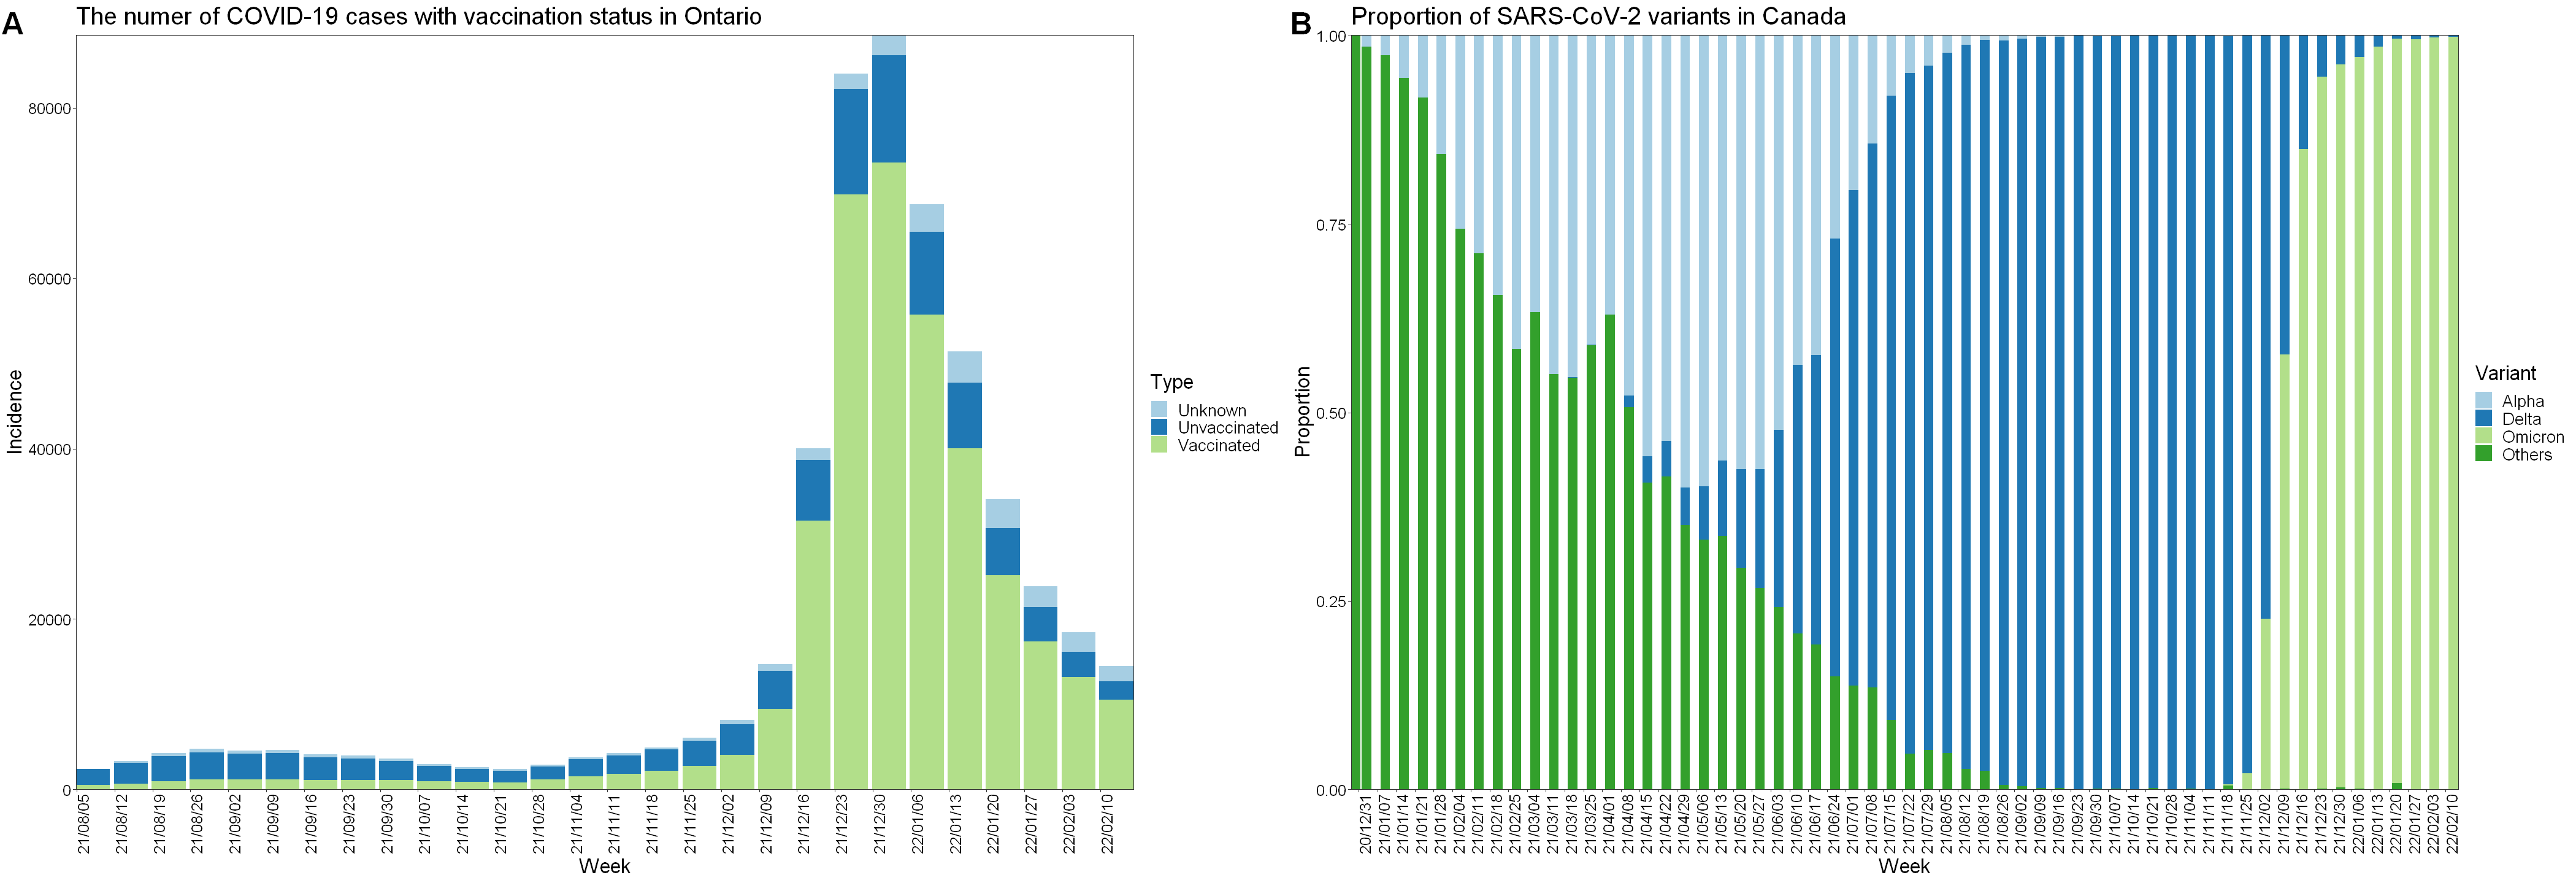

In [9]:
options(repr.plot.width=35,repr.plot.height=12)
ggarrange(ncovdata_plot,voc_plot, nrow=1,ncol=2,font.label=list(size=30),hjust=-0.1,labels=c("A","B"))

ggsave(file = "output/data_plot_ont.png", width = 35, height = 12)

#### Stan code

#### parametric approach

In [18]:
#source("src/stan/Model_Ontario_param_1.stan") # load functions
source("src/stan/Model_Ontario_param_2.stan")
#options(jupyter.plot_mimetypes = "image/svg+xml")

In [19]:
## modify data into a form suitable for Stan
delay=32
l=2 # adjustment for left censoring
m=10 # control the end of observation period 
T = nrow(ncovdata)-l-m # number of days
N = 14826276
num_data = T+l+delay
it = ncovdata$unvax_case[1:(T+l)] + ncovdata$unknown[1:(T+l)] * (ncovdata$unvax_case[1:(T+l)]/(ncovdata$unvax_case[1:(T+l)]+ncovdata$vax_case[1:(T+l)])) 
jt = ncovdata$vax_case[1:(T+l)] + ncovdata$unknown[1:(T+l)] * (ncovdata$vax_case[1:(T+l)]/(ncovdata$unvax_case[1:(T+l)]+ncovdata$vax_case[1:(T+l)])) 
others= Others$Proportion[1:(T+l+delay)]
alpha = Alpha$Proportion[1:(T+l+delay)]
delta = Delta$Proportion[1:(T+l+delay)]
vaccine= ncov_vax$vaccine[1:(T+l+delay)]/N
odds = ncov_vax$cumulative[1:(T+l+delay)]/(N-ncov_vax$cumulative[1:(T+l+delay)])
si = plnorm(seq(7, (T+l)*7, by = 7), log(4.699), log(2.936))-plnorm(seq(0, (T+l)*7-7, by = 7), log(4.699), log(2.936)) #serial interval (Nishiura et al. 2020)

data = list(T=T, N=N, it=it, jt=jt, Gamma=vaccine, SI=si, odds=odds, others=others, alpha=alpha, delta=delta, delay=delay, l=l, num_data=num_data)
# specify parameters to monitor
parameters = c("ve_o","ve_a","ve_d","zeta","eta","Rit","Rjt","k","ii","jj")
# eps: overall effect over time, ve: direct effect over time

#nuts_fit1 = stan(model_code=Model_1,data=data,pars=parameters,iter=5000,thin=10,warmup=1000,chain=2)
nuts_fit1 = stan(model_code=Model_2,data=data,pars=parameters,iter=5000,thin=10,warmup=1000,chain=2)


SAMPLING FOR MODEL '19e58be9805cc0cd7d2bed303fafc876' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.005 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 50 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 5000 [  0%]  (Warmup)
Chain 1: Iteration:  500 / 5000 [ 10%]  (Warmup)
Chain 1: Iteration: 1000 / 5000 [ 20%]  (Warmup)
Chain 1: Iteration: 1001 / 5000 [ 20%]  (Sampling)
Chain 1: Iteration: 1500 / 5000 [ 30%]  (Sampling)
Chain 1: Iteration: 2000 / 5000 [ 40%]  (Sampling)
Chain 1: Iteration: 2500 / 5000 [ 50%]  (Sampling)
Chain 1: Iteration: 3000 / 5000 [ 60%]  (Sampling)
Chain 1: Iteration: 3500 / 5000 [ 70%]  (Sampling)
Chain 1: Iteration: 4000 / 5000 [ 80%]  (Sampling)
Chain 1: Iteration: 4500 / 5000 [ 90%]  (Sampling)
Chain 1: Iteration: 5000 / 5000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 129.086 seconds (Warm-up)
Chain 1:                171.959 seconds (Sampling)


In [20]:
source("src/plot/Result_arrangement.R") # load functions
#options(jupyter.plot_mimetypes = "image/svg+xml")

In [21]:
source("src/plot/Plot_Ontario.R") # load functions
#options(jupyter.plot_mimetypes = "image/svg+xml")

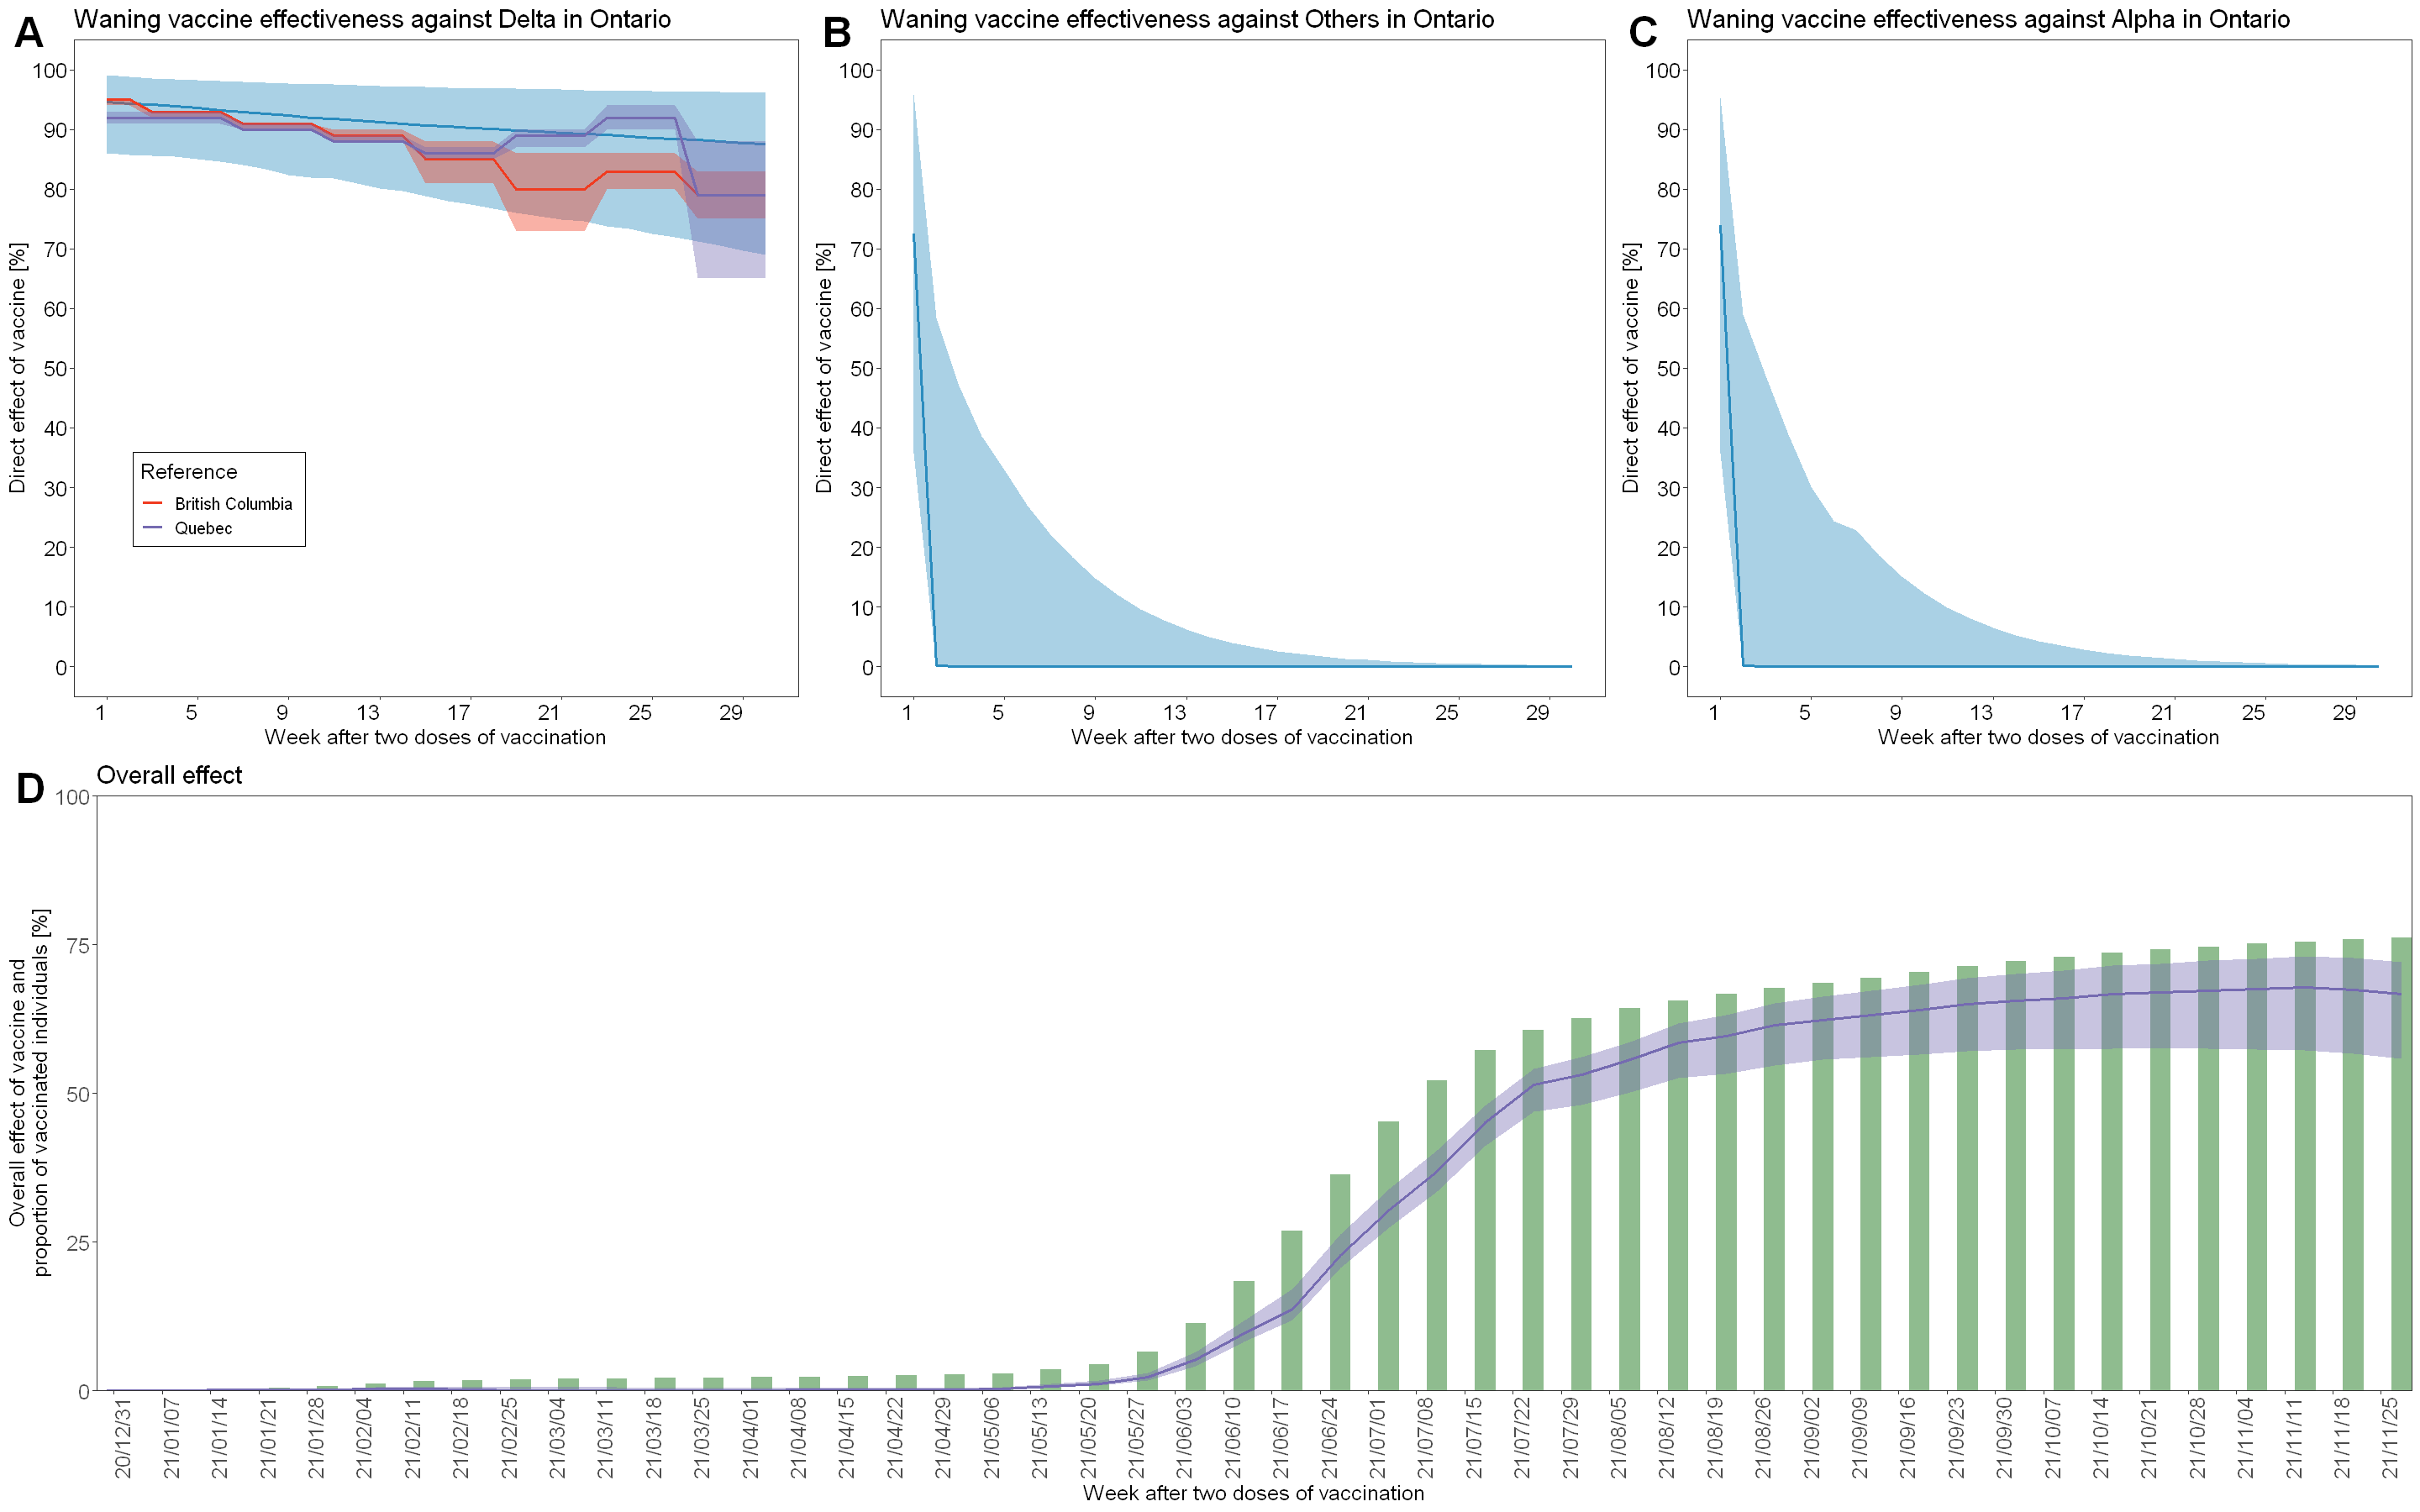

In [17]:
options(repr.plot.width=24,repr.plot.height=15)
direct_effect <- ggarrange(delta_plot,others_plot,alpha_plot, nrow=1,ncol=3,labels=c("A","B","C"),font.label=list(size=30),common.legend=FALSE)
ggarrange(direct_effect,overall_plot, nrow=2,ncol=1,font.label=list(size=30),labels=c("","D"),common.legend=FALSE)

ggsave(file = "output/VE_waning_plot_param1_Ontario.png", width = 24, height = 15)

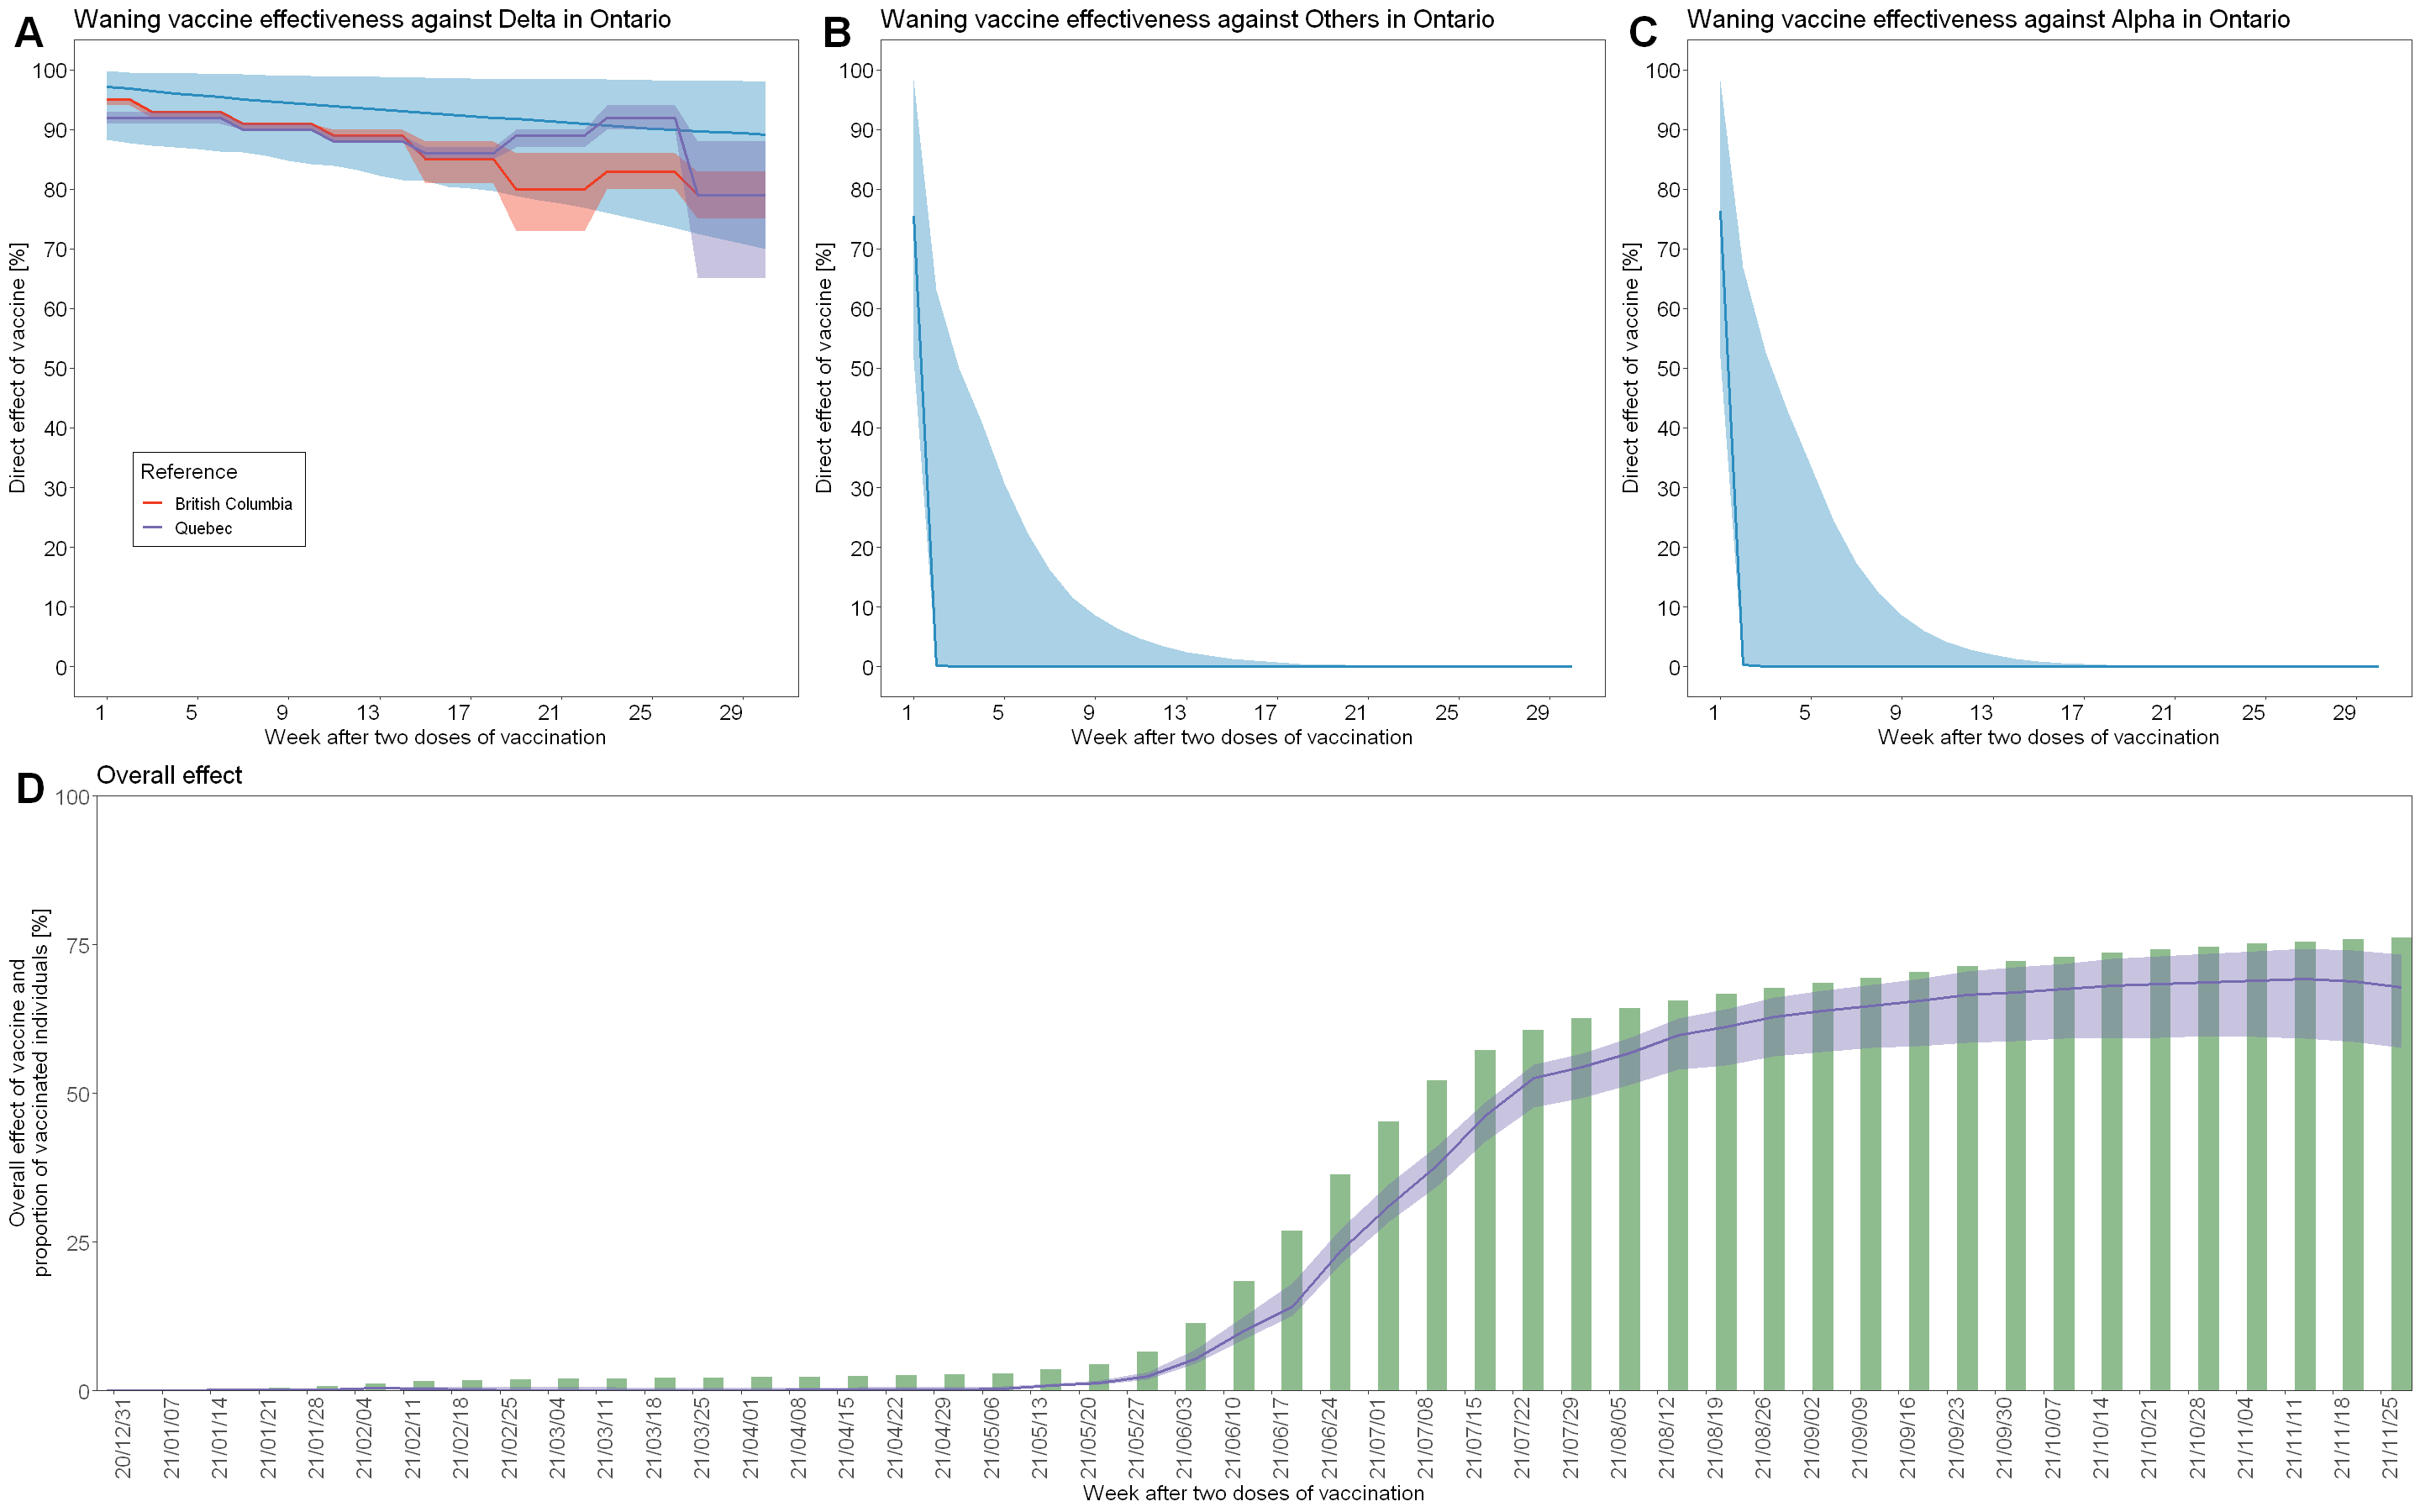

In [22]:
options(repr.plot.width=24,repr.plot.height=15)
direct_effect <- ggarrange(delta_plot,others_plot,alpha_plot, nrow=1,ncol=3,labels=c("A","B","C"),font.label=list(size=30),common.legend=FALSE)
ggarrange(direct_effect,overall_plot, nrow=2,ncol=1,font.label=list(size=30),labels=c("","D"),common.legend=FALSE)

ggsave(file = "output/VE_waning_plot_param2_Ontario.png", width = 24, height = 15)

### Check fitness

In [ ]:
source("src/plot/Fitcheck.R")

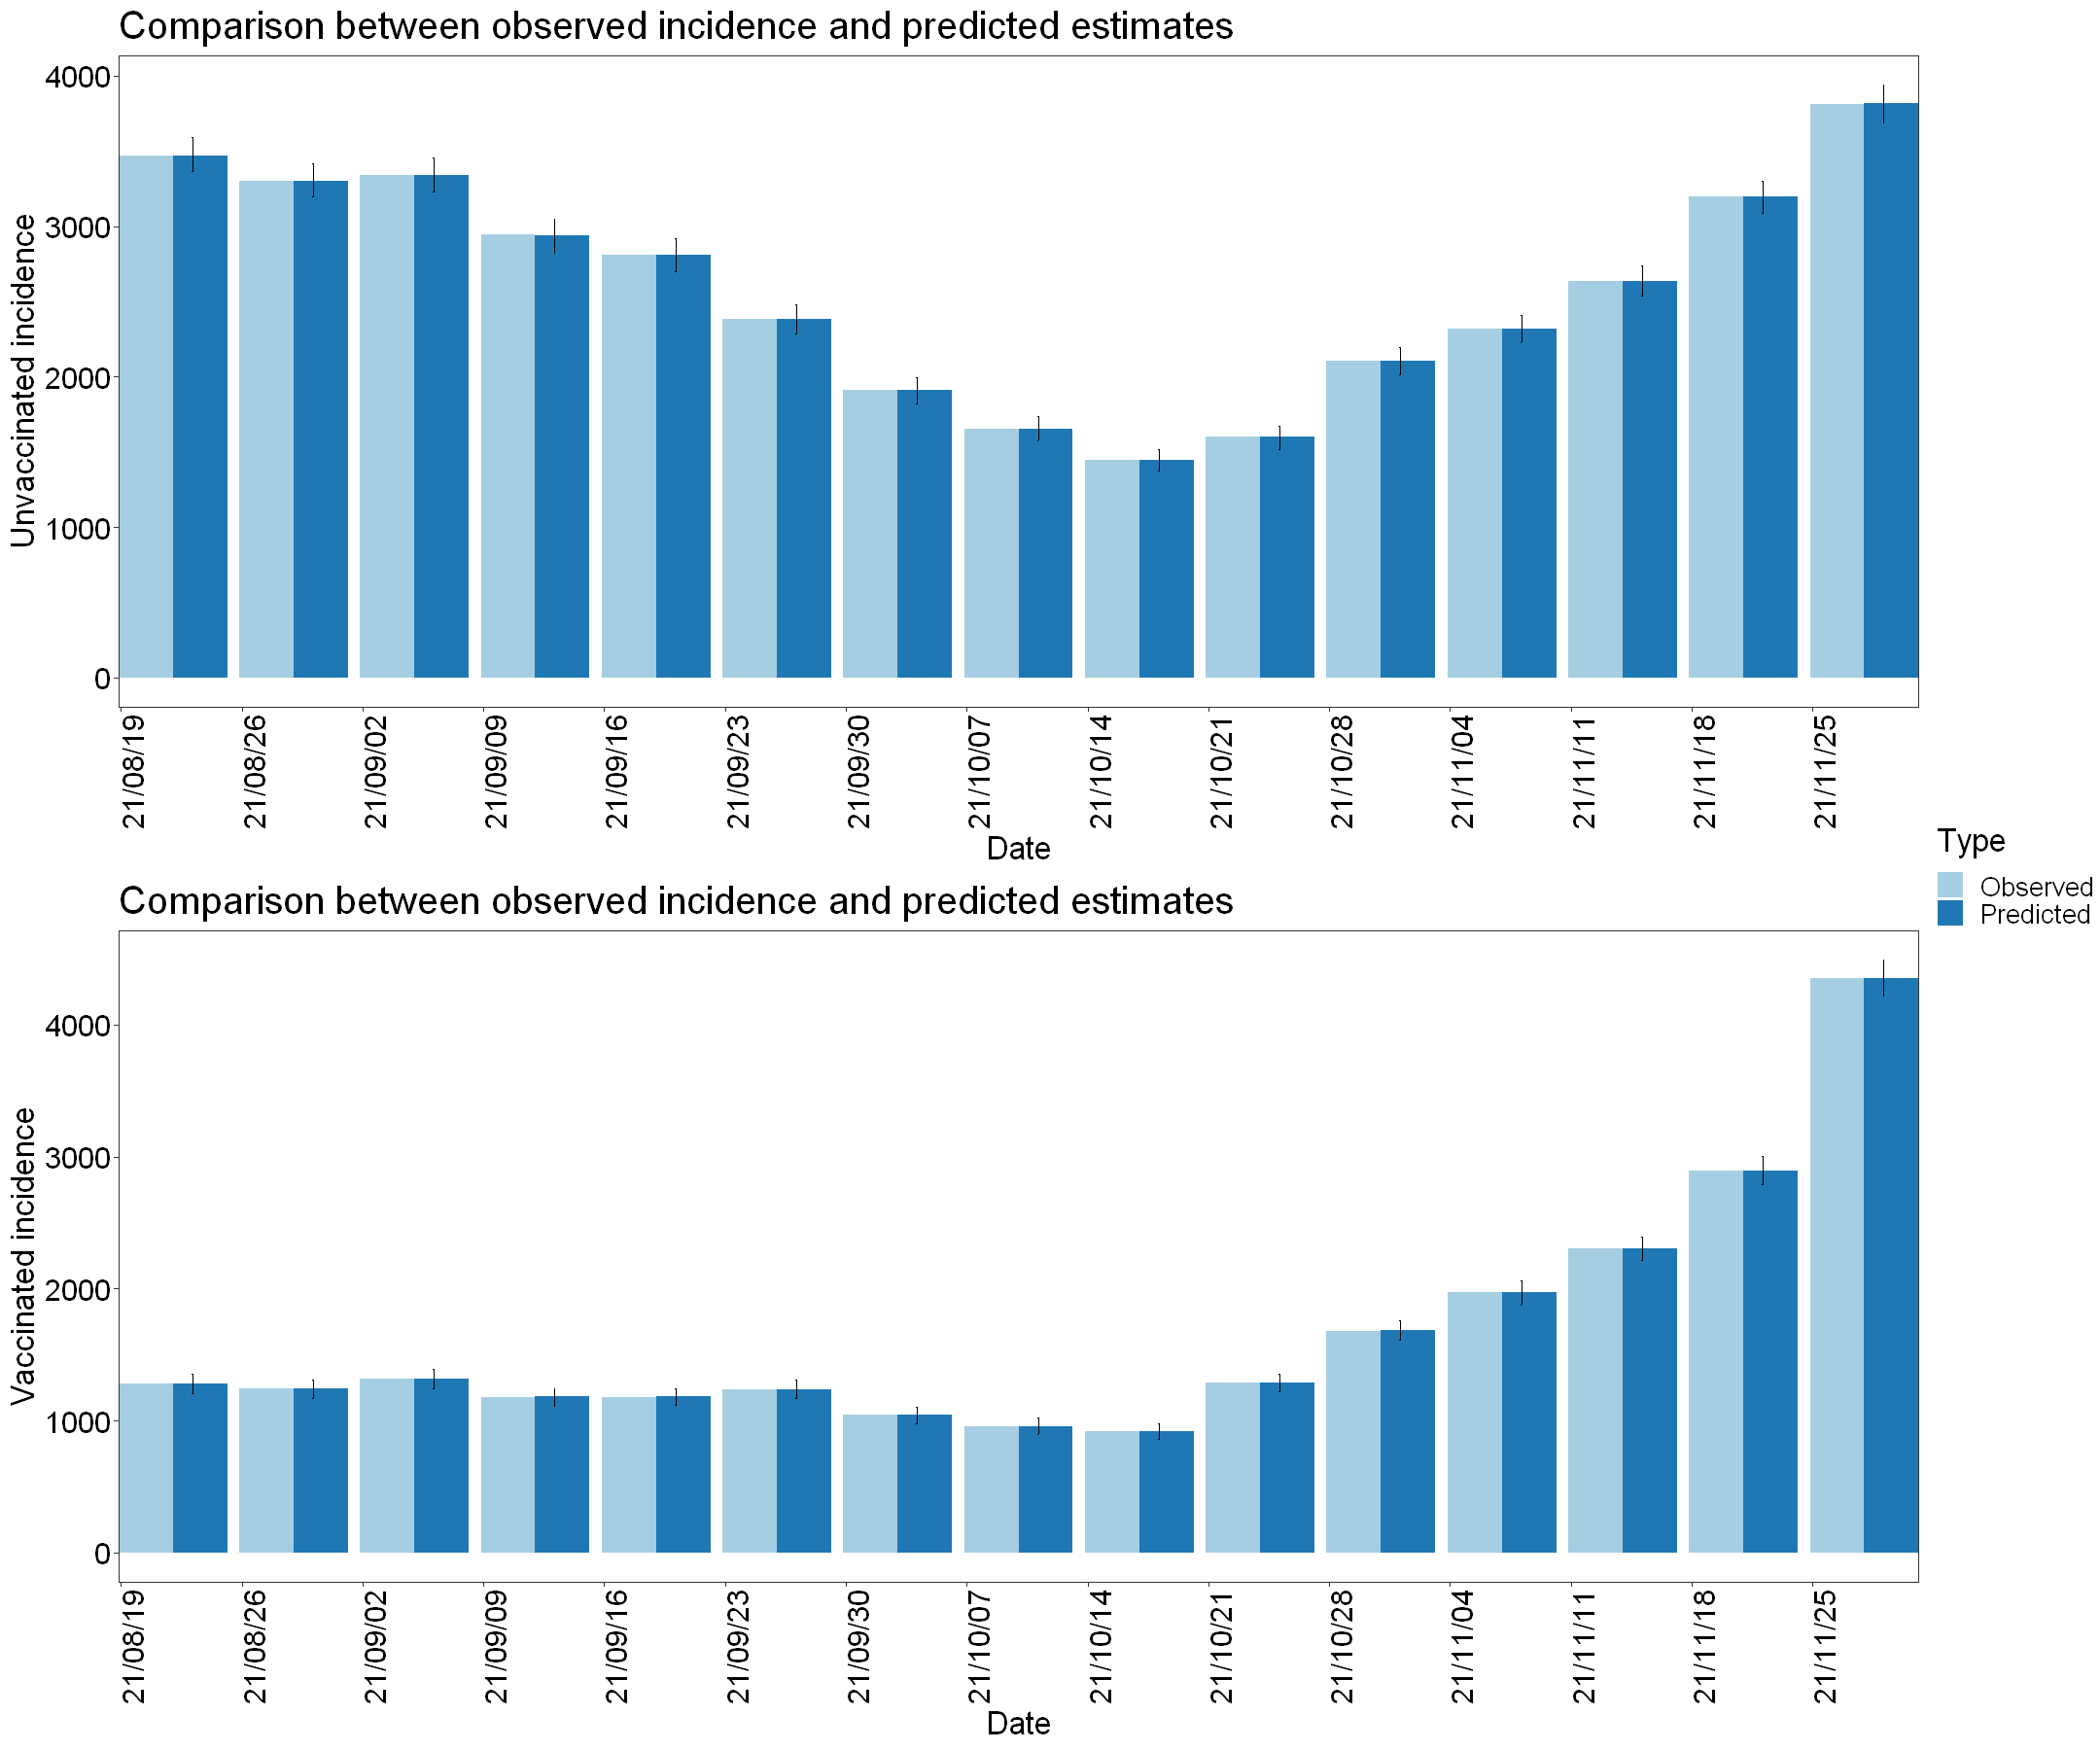

In [67]:
options(repr.plot.width=18,repr.plot.height=15)
ggarrange(u_param_plot,v_param_plot, nrow=2,ncol=1,common.legend=TRUE,legend="right")
ggsave(file = "output/fitness_plot_param1_Ontario.png", width = 18, height = 15)
#ggsave(file = "output/fitness_plot_param2_Ontario.png", width = 18, height = 15)

### spline-based approach

In [23]:
source("src/stan/Model_Ontario_spline.stan") # load functions
#options(jupyter.plot_mimetypes = "image/svg+xml")

In [24]:
# modify data into a form suitable for Stan
delay=32
l=2 # adjustment for left censoring
m= 10 # control the end of observation period 
T = nrow(ncovdata)-l-m # number of days
N = 14826276
num_data = T+l+delay
X = seq(1, num_data, by=1)
xknots = c(1, seq(8, num_data, by=8),num_data)
nknots = length(xknots)
it = ncovdata$unvax_case[1:(T+l)] + ncovdata$unknown[1:(T+l)] * (ncovdata$unvax_case[1:(T+l)]/(ncovdata$unvax_case[1:(T+l)]+ncovdata$vax_case[1:(T+l)])) 
jt = ncovdata$vax_case[1:(T+l)] + ncovdata$unknown[1:(T+l)] * (ncovdata$vax_case[1:(T+l)]/(ncovdata$unvax_case[1:(T+l)]+ncovdata$vax_case[1:(T+l)])) 
others= Others$Proportion[1:num_data]
alpha = Alpha$Proportion[1:num_data]
delta = Delta$Proportion[1:num_data]
vaccine= ncov_vax$vaccine[1:num_data]/N
odds = ncov_vax$cumulative[1:num_data]/(N-ncov_vax$cumulative[1:num_data])
si = plnorm(seq(7, (T+l)*7, by = 7), log(4.699), log(2.936))-plnorm(seq(0, (T+l)*7-7, by = 7), log(4.699), log(2.936)) #serial interval (Nishiura et al. 2020)

data = list(T=T, N=N, it=it, jt=jt, l=l,Gamma=vaccine, SI=si, odds=odds,  others=others, alpha=alpha, delta=delta, delay=delay, X=X, nknots=nknots, xknots=xknots, num_data=num_data)
# specify parameters to monitor
parameters = c("ve_o","ve_a","ve_d","zeta","Rit","Rjt","yknots_o","yknots_a","yknots_d","eta","ii","jj")
# eps: overall effect over time, ve: direct effect over time

nuts_fit1 = stan(model_code=Model_s,data=data,pars=parameters,iter=5000,thin=10,warmup=1000,chain=2)


SAMPLING FOR MODEL '1e387729b6c1a9406f05427a41bf2098' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.001 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 10 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 5000 [  0%]  (Warmup)
Chain 1: Iteration:  500 / 5000 [ 10%]  (Warmup)
Chain 1: Iteration: 1000 / 5000 [ 20%]  (Warmup)
Chain 1: Iteration: 1001 / 5000 [ 20%]  (Sampling)
Chain 1: Iteration: 1500 / 5000 [ 30%]  (Sampling)
Chain 1: Iteration: 2000 / 5000 [ 40%]  (Sampling)
Chain 1: Iteration: 2500 / 5000 [ 50%]  (Sampling)
Chain 1: Iteration: 3000 / 5000 [ 60%]  (Sampling)
Chain 1: Iteration: 3500 / 5000 [ 70%]  (Sampling)
Chain 1: Iteration: 4000 / 5000 [ 80%]  (Sampling)
Chain 1: Iteration: 4500 / 5000 [ 90%]  (Sampling)
Chain 1: Iteration: 5000 / 5000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 52.846 seconds (Warm-up)
Chain 1:                50.757 seconds (Sampling)
Ch

In [30]:
source("src/plot/Result_arrangement.R") # load functions
#options(jupyter.plot_mimetypes = "image/svg+xml")

In [31]:
source("src/plot/Plot_Ontario.R") # load functions
#options(jupyter.plot_mimetypes = "image/svg+xml")

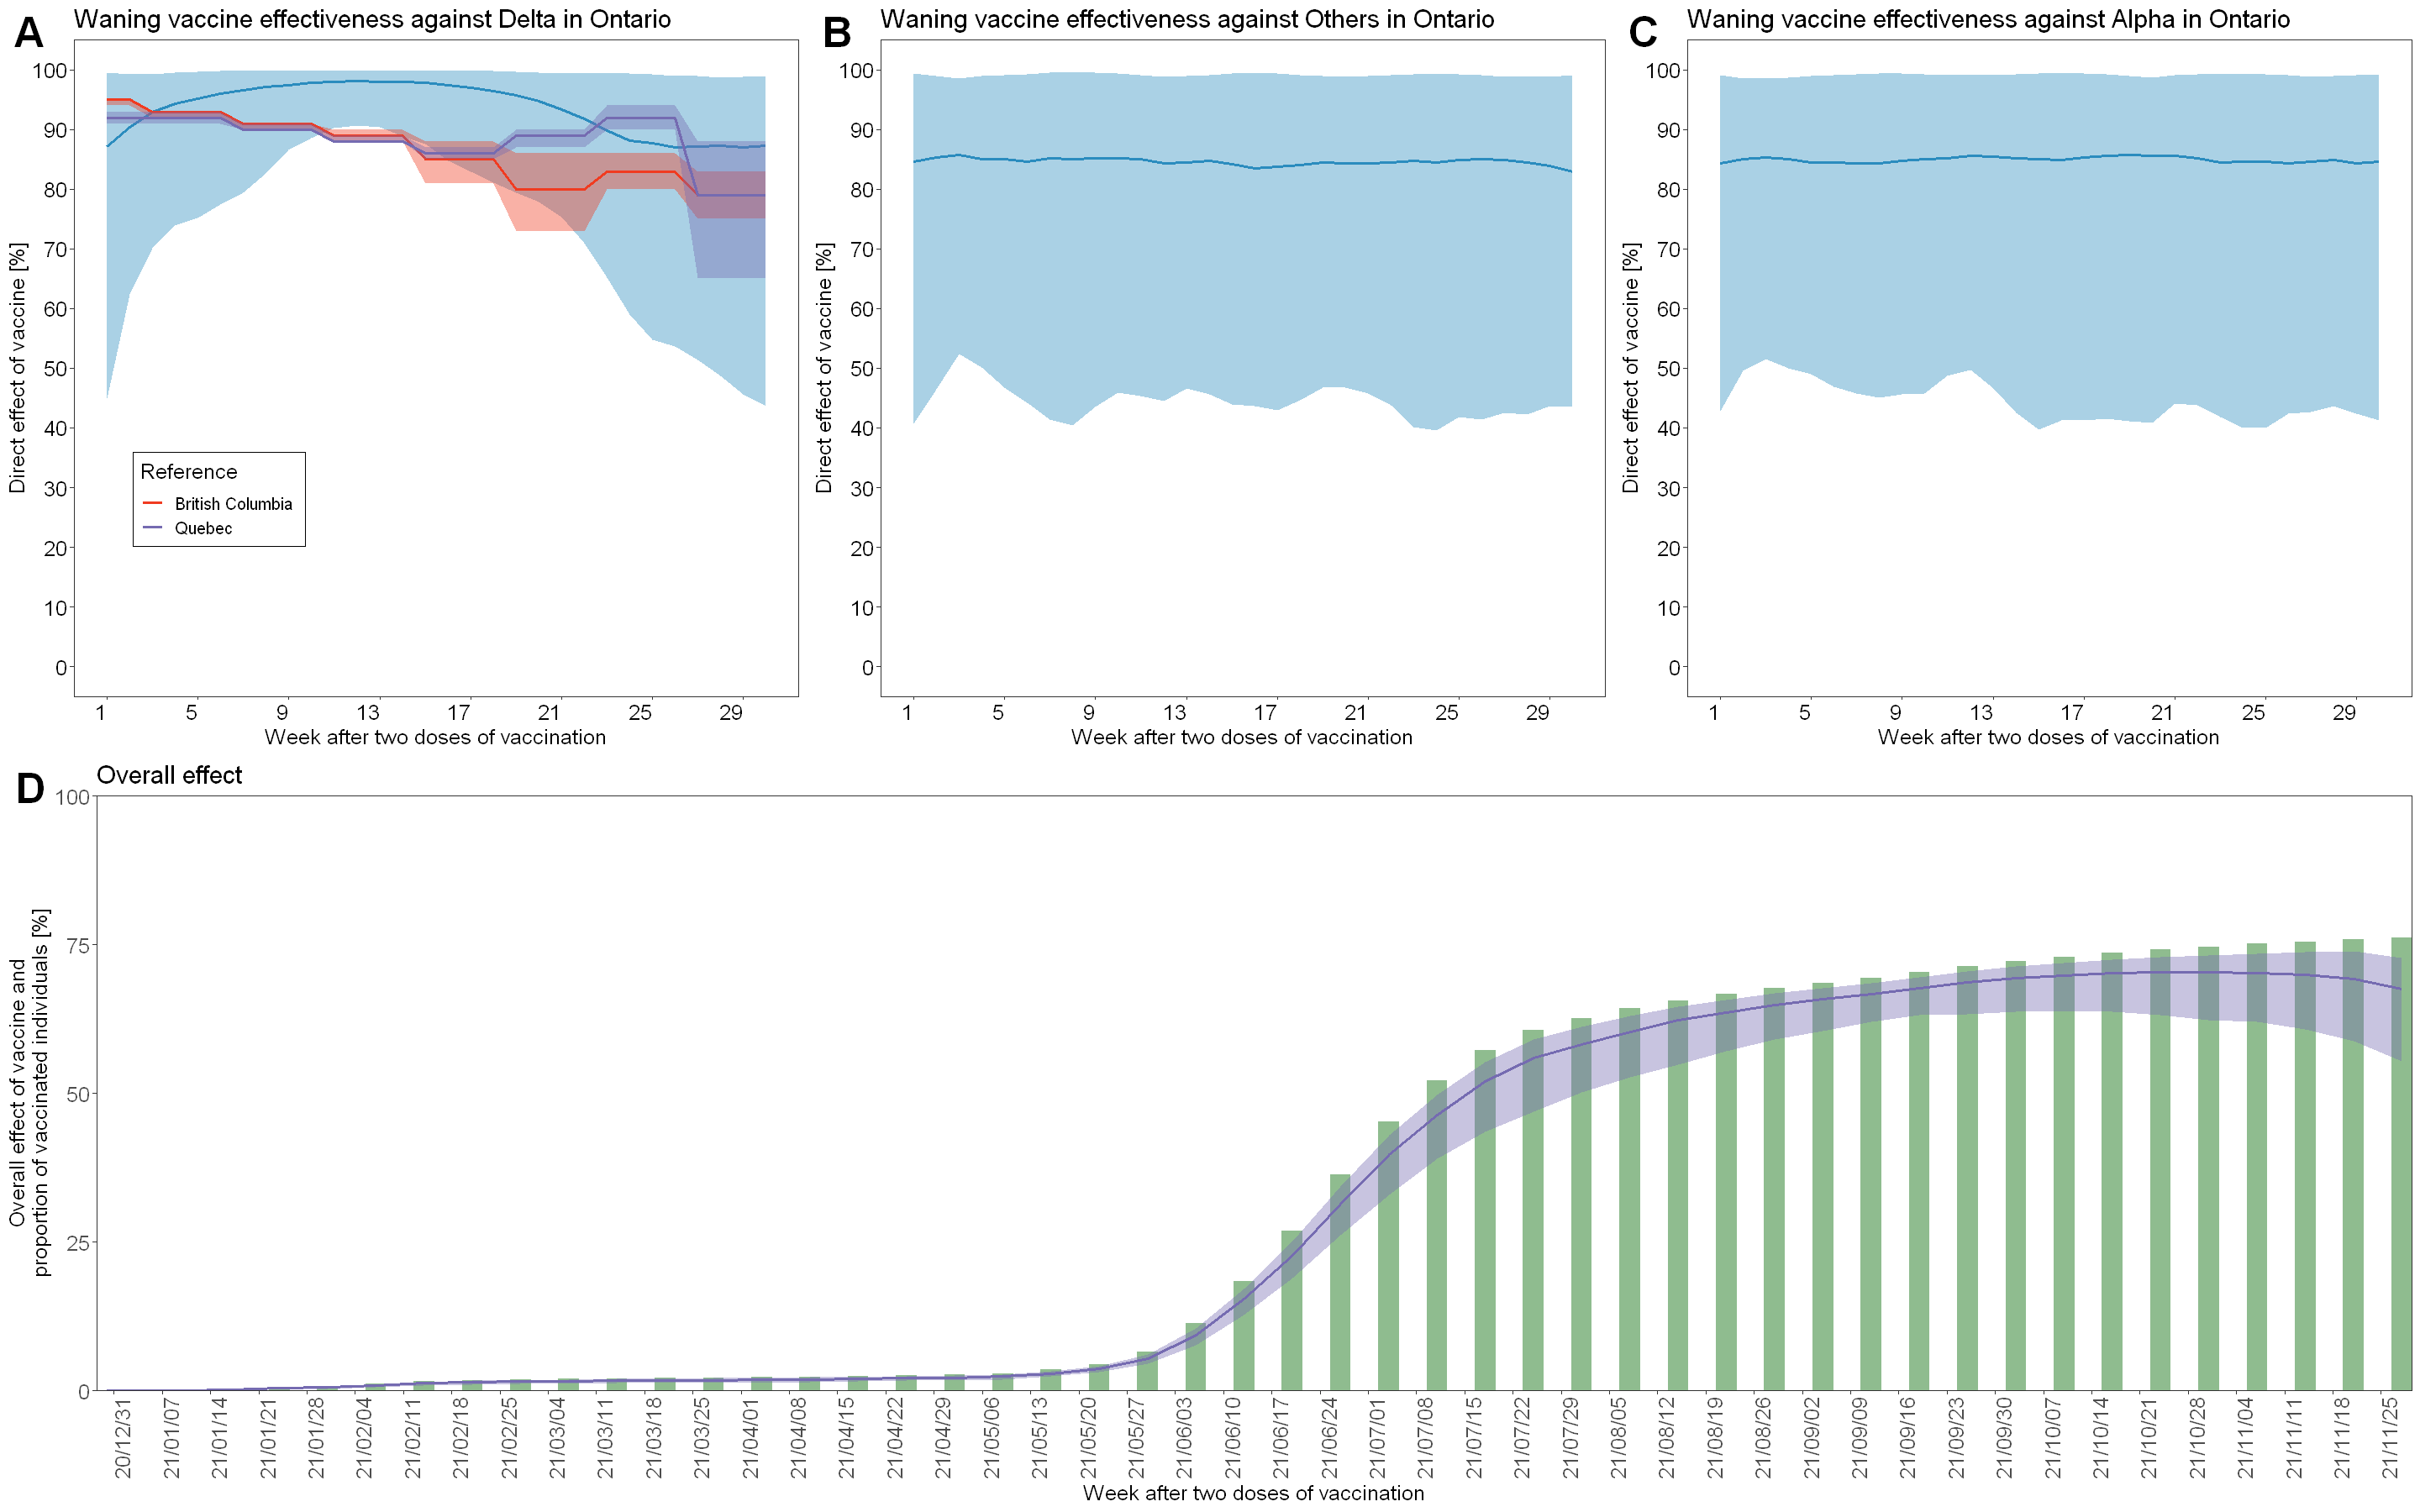

In [27]:
options(repr.plot.width=24,repr.plot.height=15)
direct_effect <- ggarrange(delta_plot,others_plot,alpha_plot, nrow=1,ncol=3,labels=c("A","B","C"),font.label=list(size=30),common.legend=FALSE)
ggarrange(direct_effect,overall_plot, nrow=2,ncol=1,font.label=list(size=30),labels=c("","D"),common.legend=FALSE)

ggsave(file = "output/VE_waning_plot_spline_Ontario.png", width = 24, height = 15)

### Check fitness

In [32]:
source("src/plot/Fitcheck.R")

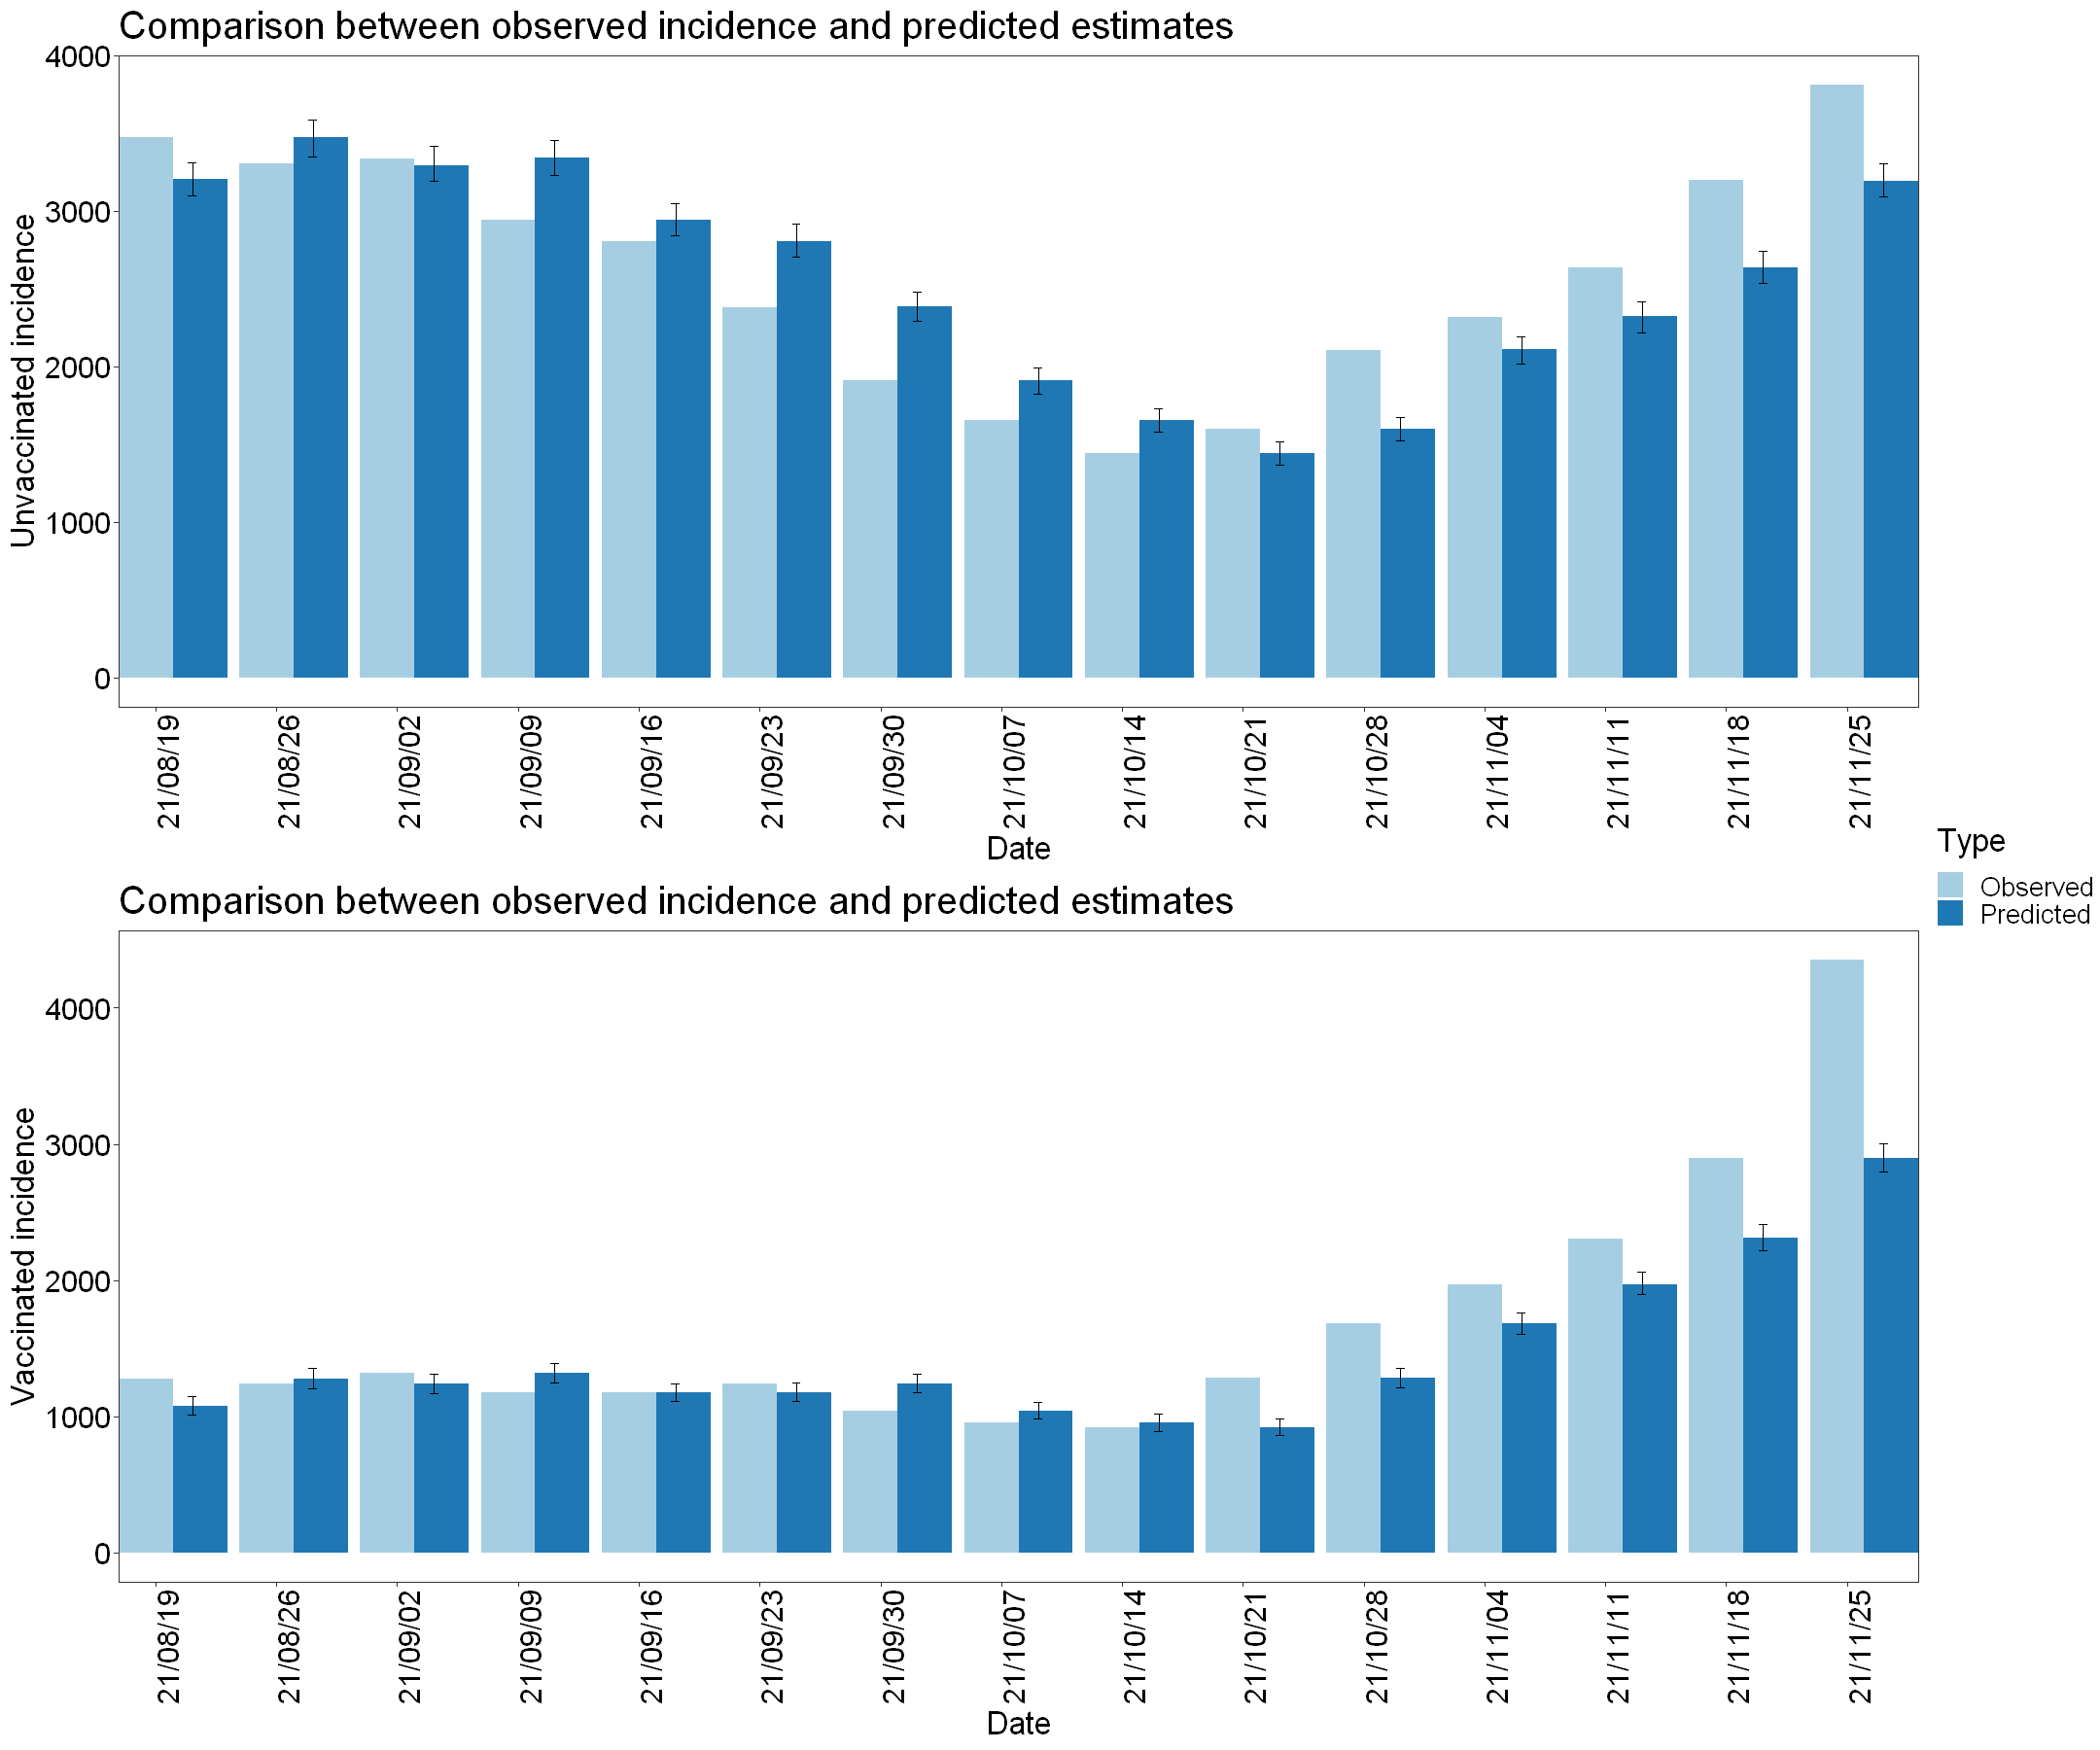

In [34]:
options(repr.plot.width=18,repr.plot.height=15)
ggarrange(u_param_plot,v_param_plot, nrow=2,ncol=1,common.legend=TRUE,legend="right")
#ggsave(file = "output/fitness_plot_spline_Ontario.png", width = 18, height = 15)